In [1]:
!nvidia-smi

Wed Oct 20 12:26:16 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip /content/drive/MyDrive/HW1/hw1_data.zip

串流輸出內容已截斷至最後 5000 行。
  inflating: p1_data/val_50/5_480.png  
  inflating: p1_data/val_50/5_484.png  
  inflating: p1_data/val_50/6_469.png  
  inflating: p1_data/val_50/6_475.png  
  inflating: p1_data/val_50/6_485.png  
  inflating: p1_data/val_50/6_490.png  
  inflating: p1_data/val_50/6_495.png  
  inflating: p1_data/val_50/7_481.png  
  inflating: p1_data/val_50/7_486.png  
  inflating: p1_data/val_50/7_495.png  
  inflating: p1_data/val_50/7_496.png  
  inflating: p1_data/val_50/8_483.png  
  inflating: p1_data/val_50/8_494.png  
  inflating: p1_data/val_50/8_495.png  
  inflating: p1_data/val_50/8_498.png  
  inflating: p1_data/val_50/9_463.png  
  inflating: p1_data/val_50/9_467.png  
  inflating: p1_data/val_50/9_493.png  
  inflating: p1_data/val_50/10_450.png  
  inflating: p1_data/val_50/11_450.png  
  inflating: p1_data/val_50/11_464.png  
  inflating: p1_data/val_50/11_469.png  
  inflating: p1_data/val_50/11_479.png  
  inflating: p1_data/val_50/11_485.png  
  inflating: 

In [ ]:
# Import necessary packages.
import os
import pandas as pd
import numpy as np
from typing import Type, Any, Callable, Union, List, Optional
from torch import Tensor
import torch
import random
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from PIL import Image, ImageEnhance, ImageOps
# "ConcatDataset" and "Subset" are possibly useful when doing semi-supervised learning.
from torch.utils.data import ConcatDataset, DataLoader, Subset, Dataset

In [ ]:
# *https://github.com/DeepVoltaire/AutoAugment/blob/master/autoaugment.py
class ImageNetPolicy(object):
    """ Randomly choose one of the best 24 Sub-policies on ImageNet.
        Example:
        >>> policy = ImageNetPolicy()
        >>> transformed = policy(image)
        Example as a PyTorch Transform:
        >>> transform=transforms.Compose([
        >>>     transforms.Resize(256),
        >>>     ImageNetPolicy(),
        >>>     transforms.ToTensor()])
    """
    def __init__(self, fillcolor=(128, 128, 128)):
        self.policies = [
            SubPolicy(0.4, "posterize", 8, 0.6, "rotate", 9, fillcolor),
            SubPolicy(0.6, "solarize", 5, 0.6, "autocontrast", 5, fillcolor),
            SubPolicy(0.8, "equalize", 8, 0.6, "equalize", 3, fillcolor),
            SubPolicy(0.6, "posterize", 7, 0.6, "posterize", 6, fillcolor),
            SubPolicy(0.4, "equalize", 7, 0.2, "solarize", 4, fillcolor),

            SubPolicy(0.4, "equalize", 4, 0.8, "rotate", 8, fillcolor),
            SubPolicy(0.6, "solarize", 3, 0.6, "equalize", 7, fillcolor),
            SubPolicy(0.8, "posterize", 5, 1.0, "equalize", 2, fillcolor),
            SubPolicy(0.2, "rotate", 3, 0.6, "solarize", 8, fillcolor),
            SubPolicy(0.6, "equalize", 8, 0.4, "posterize", 6, fillcolor),

            SubPolicy(0.8, "rotate", 8, 0.4, "color", 0, fillcolor),
            SubPolicy(0.4, "rotate", 9, 0.6, "equalize", 2, fillcolor),
            SubPolicy(0.0, "equalize", 7, 0.8, "equalize", 8, fillcolor),
            SubPolicy(0.6, "invert", 4, 1.0, "equalize", 8, fillcolor),
            SubPolicy(0.6, "color", 4, 1.0, "contrast", 8, fillcolor),

            SubPolicy(0.8, "rotate", 8, 1.0, "color", 2, fillcolor),
            SubPolicy(0.8, "color", 8, 0.8, "solarize", 7, fillcolor),
            SubPolicy(0.4, "sharpness", 7, 0.6, "invert", 8, fillcolor),
            SubPolicy(0.6, "shearX", 5, 1.0, "equalize", 9, fillcolor),
            SubPolicy(0.4, "color", 0, 0.6, "equalize", 3, fillcolor),

            SubPolicy(0.4, "equalize", 7, 0.2, "solarize", 4, fillcolor),
            SubPolicy(0.6, "solarize", 5, 0.6, "autocontrast", 5, fillcolor),
            SubPolicy(0.6, "invert", 4, 1.0, "equalize", 8, fillcolor),
            SubPolicy(0.6, "color", 4, 1.0, "contrast", 8, fillcolor),
            SubPolicy(0.8, "equalize", 8, 0.6, "equalize", 3, fillcolor)
        ]


    def __call__(self, img):
        policy_idx = random.randint(0, len(self.policies) - 1)
        return self.policies[policy_idx](img)

    def __repr__(self):
        return "AutoAugment ImageNet Policy"


class CIFAR10Policy(object):
    """ Randomly choose one of the best 25 Sub-policies on CIFAR10.
        Example:
        >>> policy = CIFAR10Policy()
        >>> transformed = policy(image)
        Example as a PyTorch Transform:
        >>> transform=transforms.Compose([
        >>>     transforms.Resize(256),
        >>>     CIFAR10Policy(),
        >>>     transforms.ToTensor()])
    """
    def __init__(self, fillcolor=(128, 128, 128)):
        self.policies = [
            SubPolicy(0.1, "invert", 7, 0.2, "contrast", 6, fillcolor),
            SubPolicy(0.7, "rotate", 2, 0.3, "translateX", 9, fillcolor),
            SubPolicy(0.8, "sharpness", 1, 0.9, "sharpness", 3, fillcolor),
            SubPolicy(0.5, "shearY", 8, 0.7, "translateY", 9, fillcolor),
            SubPolicy(0.5, "autocontrast", 8, 0.9, "equalize", 2, fillcolor),

            SubPolicy(0.2, "shearY", 7, 0.3, "posterize", 7, fillcolor),
            SubPolicy(0.4, "color", 3, 0.6, "brightness", 7, fillcolor),
            SubPolicy(0.3, "sharpness", 9, 0.7, "brightness", 9, fillcolor),
            SubPolicy(0.6, "equalize", 5, 0.5, "equalize", 1, fillcolor),
            SubPolicy(0.6, "contrast", 7, 0.6, "sharpness", 5, fillcolor),

            SubPolicy(0.7, "color", 7, 0.5, "translateX", 8, fillcolor),
            SubPolicy(0.3, "equalize", 7, 0.4, "autocontrast", 8, fillcolor),
            SubPolicy(0.4, "translateY", 3, 0.2, "sharpness", 6, fillcolor),
            SubPolicy(0.9, "brightness", 6, 0.2, "color", 8, fillcolor),
            SubPolicy(0.5, "solarize", 2, 0.0, "invert", 3, fillcolor),

            SubPolicy(0.2, "equalize", 0, 0.6, "autocontrast", 0, fillcolor),
            SubPolicy(0.2, "equalize", 8, 0.6, "equalize", 4, fillcolor),
            SubPolicy(0.9, "color", 9, 0.6, "equalize", 6, fillcolor),
            SubPolicy(0.8, "autocontrast", 4, 0.2, "solarize", 8, fillcolor),
            SubPolicy(0.1, "brightness", 3, 0.7, "color", 0, fillcolor),

            SubPolicy(0.4, "solarize", 5, 0.9, "autocontrast", 3, fillcolor),
            SubPolicy(0.9, "translateY", 9, 0.7, "translateY", 9, fillcolor),
            SubPolicy(0.9, "autocontrast", 2, 0.8, "solarize", 3, fillcolor),
            SubPolicy(0.8, "equalize", 8, 0.1, "invert", 3, fillcolor),
            SubPolicy(0.7, "translateY", 9, 0.9, "autocontrast", 1, fillcolor)
        ]


    def __call__(self, img):
        policy_idx = random.randint(0, len(self.policies) - 1)
        return self.policies[policy_idx](img)

    def __repr__(self):
        return "AutoAugment CIFAR10 Policy"


class SVHNPolicy(object):
    """ Randomly choose one of the best 25 Sub-policies on SVHN.
        Example:
        >>> policy = SVHNPolicy()
        >>> transformed = policy(image)
        Example as a PyTorch Transform:
        >>> transform=transforms.Compose([
        >>>     transforms.Resize(256),
        >>>     SVHNPolicy(),
        >>>     transforms.ToTensor()])
    """
    def __init__(self, fillcolor=(128, 128, 128)):
        self.policies = [
            SubPolicy(0.9, "shearX", 4, 0.2, "invert", 3, fillcolor),
            SubPolicy(0.9, "shearY", 8, 0.7, "invert", 5, fillcolor),
            SubPolicy(0.6, "equalize", 5, 0.6, "solarize", 6, fillcolor),
            SubPolicy(0.9, "invert", 3, 0.6, "equalize", 3, fillcolor),
            SubPolicy(0.6, "equalize", 1, 0.9, "rotate", 3, fillcolor),

            SubPolicy(0.9, "shearX", 4, 0.8, "autocontrast", 3, fillcolor),
            SubPolicy(0.9, "shearY", 8, 0.4, "invert", 5, fillcolor),
            SubPolicy(0.9, "shearY", 5, 0.2, "solarize", 6, fillcolor),
            SubPolicy(0.9, "invert", 6, 0.8, "autocontrast", 1, fillcolor),
            SubPolicy(0.6, "equalize", 3, 0.9, "rotate", 3, fillcolor),

            SubPolicy(0.9, "shearX", 4, 0.3, "solarize", 3, fillcolor),
            SubPolicy(0.8, "shearY", 8, 0.7, "invert", 4, fillcolor),
            SubPolicy(0.9, "equalize", 5, 0.6, "translateY", 6, fillcolor),
            SubPolicy(0.9, "invert", 4, 0.6, "equalize", 7, fillcolor),
            SubPolicy(0.3, "contrast", 3, 0.8, "rotate", 4, fillcolor),

            SubPolicy(0.8, "invert", 5, 0.0, "translateY", 2, fillcolor),
            SubPolicy(0.7, "shearY", 6, 0.4, "solarize", 8, fillcolor),
            SubPolicy(0.6, "invert", 4, 0.8, "rotate", 4, fillcolor),
            SubPolicy(0.3, "shearY", 7, 0.9, "translateX", 3, fillcolor),
            SubPolicy(0.1, "shearX", 6, 0.6, "invert", 5, fillcolor),

            SubPolicy(0.7, "solarize", 2, 0.6, "translateY", 7, fillcolor),
            SubPolicy(0.8, "shearY", 4, 0.8, "invert", 8, fillcolor),
            SubPolicy(0.7, "shearX", 9, 0.8, "translateY", 3, fillcolor),
            SubPolicy(0.8, "shearY", 5, 0.7, "autocontrast", 3, fillcolor),
            SubPolicy(0.7, "shearX", 2, 0.1, "invert", 5, fillcolor)
        ]


    def __call__(self, img):
        policy_idx = random.randint(0, len(self.policies) - 1)
        return self.policies[policy_idx](img)

    def __repr__(self):
        return "AutoAugment SVHN Policy"


class SubPolicy(object):
    def __init__(self, p1, operation1, magnitude_idx1, p2, operation2, magnitude_idx2, fillcolor=(128, 128, 128)):
        ranges = {
            "shearX": np.linspace(0, 0.3, 10),
            "shearY": np.linspace(0, 0.3, 10),
            "translateX": np.linspace(0, 150 / 331, 10),
            "translateY": np.linspace(0, 150 / 331, 10),
            "rotate": np.linspace(0, 30, 10),
            "color": np.linspace(0.0, 0.9, 10),
            "posterize": np.round(np.linspace(8, 4, 10), 0).astype(np.int),
            "solarize": np.linspace(256, 0, 10),
            "contrast": np.linspace(0.0, 0.9, 10),
            "sharpness": np.linspace(0.0, 0.9, 10),
            "brightness": np.linspace(0.0, 0.9, 10),
            "autocontrast": [0] * 10,
            "equalize": [0] * 10,
            "invert": [0] * 10
        }

        # from https://stackoverflow.com/questions/5252170/specify-image-filling-color-when-rotating-in-python-with-pil-and-setting-expand
        def rotate_with_fill(img, magnitude):
            rot = img.convert("RGBA").rotate(magnitude)
            return Image.composite(rot, Image.new("RGBA", rot.size, (128,) * 4), rot).convert(img.mode)

        func = {
            "shearX": lambda img, magnitude: img.transform(
                img.size, Image.AFFINE, (1, magnitude * random.choice([-1, 1]), 0, 0, 1, 0),
                Image.BICUBIC, fillcolor=fillcolor),
            "shearY": lambda img, magnitude: img.transform(
                img.size, Image.AFFINE, (1, 0, 0, magnitude * random.choice([-1, 1]), 1, 0),
                Image.BICUBIC, fillcolor=fillcolor),
            "translateX": lambda img, magnitude: img.transform(
                img.size, Image.AFFINE, (1, 0, magnitude * img.size[0] * random.choice([-1, 1]), 0, 1, 0),
                fillcolor=fillcolor),
            "translateY": lambda img, magnitude: img.transform(
                img.size, Image.AFFINE, (1, 0, 0, 0, 1, magnitude * img.size[1] * random.choice([-1, 1])),
                fillcolor=fillcolor),
            "rotate": lambda img, magnitude: rotate_with_fill(img, magnitude),
            "color": lambda img, magnitude: ImageEnhance.Color(img).enhance(1 + magnitude * random.choice([-1, 1])),
            "posterize": lambda img, magnitude: ImageOps.posterize(img, magnitude),
            "solarize": lambda img, magnitude: ImageOps.solarize(img, magnitude),
            "contrast": lambda img, magnitude: ImageEnhance.Contrast(img).enhance(
                1 + magnitude * random.choice([-1, 1])),
            "sharpness": lambda img, magnitude: ImageEnhance.Sharpness(img).enhance(
                1 + magnitude * random.choice([-1, 1])),
            "brightness": lambda img, magnitude: ImageEnhance.Brightness(img).enhance(
                1 + magnitude * random.choice([-1, 1])),
            "autocontrast": lambda img, magnitude: ImageOps.autocontrast(img),
            "equalize": lambda img, magnitude: ImageOps.equalize(img),
            "invert": lambda img, magnitude: ImageOps.invert(img)
        }

        self.p1 = p1
        self.operation1 = func[operation1]
        self.magnitude1 = ranges[operation1][magnitude_idx1]
        self.p2 = p2
        self.operation2 = func[operation2]
        self.magnitude2 = ranges[operation2][magnitude_idx2]


    def __call__(self, img):
        if random.random() < self.p1: img = self.operation1(img, self.magnitude1)
        if random.random() < self.p2: img = self.operation2(img, self.magnitude2)
        return img

In [ ]:
# It is important to do data augmentation in training.
# However, not every augmentation is useful.
# Please think about what kind of augmentation is helpful for food recognition.
train_tfm = transforms.Compose([
    # Resize the image into a fixed shape (height = width = 128)
    transforms.Resize((299, 299)),
    # You may add some transforms here.
    transforms.RandomHorizontalFlip(p = 0.5),
    #transforms.RandomResizedCrop((28, 28)), 
    #transforms.RandomRotation(45),
    #transforms.CenterCrop(32),
    # transforms.ColorJitter( contrast = 1.5, saturation=0.5), #brightness = 0.5
    #transforms.RandomVerticalFlip(p=0.5),
    ImageNetPolicy(),
    # ToTensor() should be the last one of the transforms.
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# We don't need augmentations in testing and validation.
# All we need here is to resize the PIL image and transform it into Tensor.
test_tfm = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
# Batch size for training, validation, and testing.
# A greater batch size usually gives a more stable gradient.
# But the GPU memory is limited, so please adjust it carefully.
# I construct a dataframe to mapping image name and image class.


batch_size = 32

class Image_Dataset(Dataset):
  def __init__(self, root_dir, transforms=None):
    self.root_dir = root_dir
    self.imgname = os.listdir(self.root_dir)
    self.label_dataframe = pd.DataFrame(data={'name': self.imgname})
    self.label_dataframe['label'] = self.label_dataframe['name'].apply(lambda x: int(x.split('_')[0])) #name	label / 49_172.png	49/ 11_42.png 11/ 14_0.png 14
    # print(self.label_dataframe)
    self.transforms = transforms

  def __len__(self):
    return len(self.label_dataframe)

  def __getitem__(self, index):
    image_path = os.path.join(self.root_dir, self.label_dataframe.iloc[index, 0])
    image = Image.open(image_path)
    image_label = torch.tensor(self.label_dataframe.iloc[index, 1])
    if transforms:
      image = self.transforms(image)
    
    return (image, image_label)


train_set = Image_Dataset('/content/p1_data/train_50', transforms=train_tfm)
valid_set = Image_Dataset('/content/p1_data/val_50', transforms=test_tfm)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=6, pin_memory=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=6, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:

# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"


# Initialize a model, and put it on the device specified.
model = torchvision.models.inception_v3(aux_logits=False, pretrained=True)
model.to(device)

try:
  model.load_state_dict(torch.load('/content/drive/MyDrive/HW1/model/inv3.pth'))
  model.device = device
except:
  pass

# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
#optimizer = torch.optim.Adam(model.parameters(), lr=3.375e-05, weight_decay=1e-5)
optimizer = torch.optim.SGD(model.parameters(), lr=0.0015, momentum=0.9)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
        factor=0.5, patience=10, verbose=True, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)
# The number of training epochs.
n_epochs = 20
max_val = 0
for epoch in range(n_epochs):
  # Make sure the model is in train mode before training.
  model.train()


  # These are used to record information in training.
  train_loss = []
  train_accs = []

  # Iterate the training set by batches.
  for batch in train_loader:
    # A batch consists of image data and corresponding labels.
    imgs, labels = batch

    # Forward the data. (Make sure data and model are on the same device.)
    logits = model(imgs.to(device))
    # Calculate the cross-entropy loss.
    # We don't need to apply softmax before computing cross-entropy as it is done automatically.
    loss = criterion(logits, labels.to(device))

    # Gradients stored in the parameters in the previous step should be cleared out first.
    optimizer.zero_grad()

    # Compute the gradients for parameters.
    loss.backward()

    # Clip the gradient norms for stable training.
    grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

    # Update the parameters with computed gradients.
    optimizer.step()
    

    # Compute the accuracy for current batch.
    acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

    # Record the loss and accuracy.
    train_loss.append(loss.item())
    train_accs.append(acc)

  # The average loss and accuracy of the training set is the average of the recorded values.
  train_loss = sum(train_loss) / len(train_loss)
  train_acc = sum(train_accs) / len(train_accs)
  lr_scheduler.step(train_loss)

  # Print the information.
  print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] train_loss = {train_loss:.5f}, train_acc = {train_acc:.5f}")
  print(optimizer.param_groups[0]['lr'])


  # ---------- Validation ----------
  # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
  model.eval()

  # These are used to record information in validation.
  valid_loss = []
  valid_accs = []

  # Iterate the validation set by batches.
  for batch in valid_loader:

    # A batch consists of image data and corresponding labels.
    imgs, labels = batch

    # We don't need gradient in validation.
    # Using torch.no_grad() accelerates the forward process.
    with torch.no_grad():
      logits = model(imgs.to(device))

    # We can still compute the loss (but not the gradient).
    loss = criterion(logits, labels.to(device))

    # Compute the accuracy for current batch.
    acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

    # Record the loss and accuracy.
    valid_loss.append(loss.item())
    valid_accs.append(acc)

  # The average loss and accuracy for entire validation set is the average of the recorded values.
  valid_loss = sum(valid_loss) / len(valid_loss)
  valid_acc = sum(valid_accs) / len(valid_accs)

  # Print the information.

  print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] val_loss = {valid_loss:.5f}, val_acc = {valid_acc:.5f}")
  if (valid_acc > max_val):
    max_val = valid_acc
    torch.save(model.state_dict(), '/content/drive/MyDrive/HW1/model/inv3.pth')

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

  0%|          | 0/704 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100%|██████████| 704/704 [12:46<00:00,  1.09s/it]


[ Train | 001/010 ] train_loss = 0.34607, train_acc = 0.89591
0.0015


100%|██████████| 79/79 [00:24<00:00,  3.19it/s]


[ Valid | 001/010 ] val_loss = 0.51232, val_acc = 0.85957


100%|██████████| 704/704 [12:45<00:00,  1.09s/it]


[ Train | 002/010 ] train_loss = 0.31147, train_acc = 0.90297
0.0015


100%|██████████| 79/79 [00:24<00:00,  3.24it/s]


[ Valid | 002/010 ] val_loss = 0.49897, val_acc = 0.86313


100%|██████████| 704/704 [12:44<00:00,  1.09s/it]


[ Train | 003/010 ] train_loss = 0.26922, train_acc = 0.91846
0.0015


100%|██████████| 79/79 [00:24<00:00,  3.22it/s]


[ Valid | 003/010 ] val_loss = 0.51550, val_acc = 0.85166


100%|██████████| 704/704 [12:45<00:00,  1.09s/it]


[ Train | 004/010 ] train_loss = 0.27144, train_acc = 0.91717
0.0015


100%|██████████| 79/79 [00:24<00:00,  3.21it/s]


[ Valid | 004/010 ] val_loss = 0.52555, val_acc = 0.86551


100%|██████████| 704/704 [12:44<00:00,  1.09s/it]


[ Train | 005/010 ] train_loss = 0.23401, train_acc = 0.92884
0.0015


100%|██████████| 79/79 [00:24<00:00,  3.23it/s]


[ Valid | 005/010 ] val_loss = 0.51683, val_acc = 0.86274


100%|██████████| 704/704 [12:44<00:00,  1.09s/it]


[ Train | 006/010 ] train_loss = 0.21303, train_acc = 0.93422
0.0015


100%|██████████| 79/79 [00:24<00:00,  3.23it/s]


[ Valid | 006/010 ] val_loss = 0.55019, val_acc = 0.85839


100%|██████████| 704/704 [12:45<00:00,  1.09s/it]


[ Train | 007/010 ] train_loss = 0.21116, train_acc = 0.93599
0.0015


100%|██████████| 79/79 [00:24<00:00,  3.22it/s]


[ Valid | 007/010 ] val_loss = 0.56642, val_acc = 0.85601


100%|██████████| 704/704 [12:44<00:00,  1.09s/it]


[ Train | 008/010 ] train_loss = 0.19217, train_acc = 0.94203
0.0015


100%|██████████| 79/79 [00:24<00:00,  3.22it/s]


[ Valid | 008/010 ] val_loss = 0.58477, val_acc = 0.84771


100%|██████████| 704/704 [12:44<00:00,  1.09s/it]


[ Train | 009/010 ] train_loss = 0.18784, train_acc = 0.94323
0.0015


100%|██████████| 79/79 [00:24<00:00,  3.23it/s]


[ Valid | 009/010 ] val_loss = 0.55784, val_acc = 0.85680


100%|██████████| 704/704 [12:45<00:00,  1.09s/it]


[ Train | 010/010 ] train_loss = 0.16762, train_acc = 0.94873
0.0015


100%|██████████| 79/79 [00:24<00:00,  3.23it/s]

[ Valid | 010/010 ] val_loss = 0.58286, val_acc = 0.85403


# Loading Model

In [116]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = torchvision.models.inception_v3(aux_logits=False, pretrained=True)
model.load_state_dict(torch.load('/content/drive/MyDrive/HW1/model/inv3.pth'))
model.to(device)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

# Prediction

In [117]:
out = []

# return list siez of (lenght = N/batchsize), (batchsize x layer output dimension) on every list item.  
# Get the output from specific layer.
def hook(module, input, output):
  out.append(output) 

model.avgpool.register_forward_hook(hook) # Add this line that you can automatically store the specific output.
model.eval()

predictions = []
valid_accs = []
y_label = []

for batch in valid_loader:
   
  imgs, labels = batch
  y_label.append(labels)

  # Using torch.no_grad() accelerates the forward process.
  with torch.no_grad():
    logits = model(imgs.to(device)) # The shape of logits is batchsize x layer output dimension.

  # Take the class with greatest logit as prediction and record it.
  predictions.extend(logits.argmax(dim=-1).cpu().numpy().tolist())
  acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()
  valid_accs.append(acc)

valid_acc = sum(valid_accs) / len(valid_accs)
print("val_acc = ", str(round(valid_acc.item(), 4)))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


val_acc =  0.8655


In [140]:

outputs = []
for batch in range(len(out)):
  for i in np.array(out[batch].to('cpu')):
    outputs.append(i.reshape(1, -1)[0].reshape(1, -1)[0]) # reshape to 1 x dimension
# we got N x fearure number dimension after flatten the output. (batchsize shape)

outputs = np.array(outputs)
print('The shape of outputs:', outputs.shape)

y = []
for i in y_label:
  for j in i:
    y.append(j.item())
y = np.array(y)

print('The shape of label:', y.shape)


The shape of outputs: (2500, 2048)
The shape of label: (2500,)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2500 samples in 0.457s...
[t-SNE] Computed neighbors for 2500 samples in 24.213s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2500
[t-SNE] Computed conditional probabilities for sample 2000 / 2500
[t-SNE] Computed conditional probabilities for sample 2500 / 2500
[t-SNE] Mean sigma: 4.055900
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.211033
[t-SNE] KL divergence after 2000 iterations: 0.683602


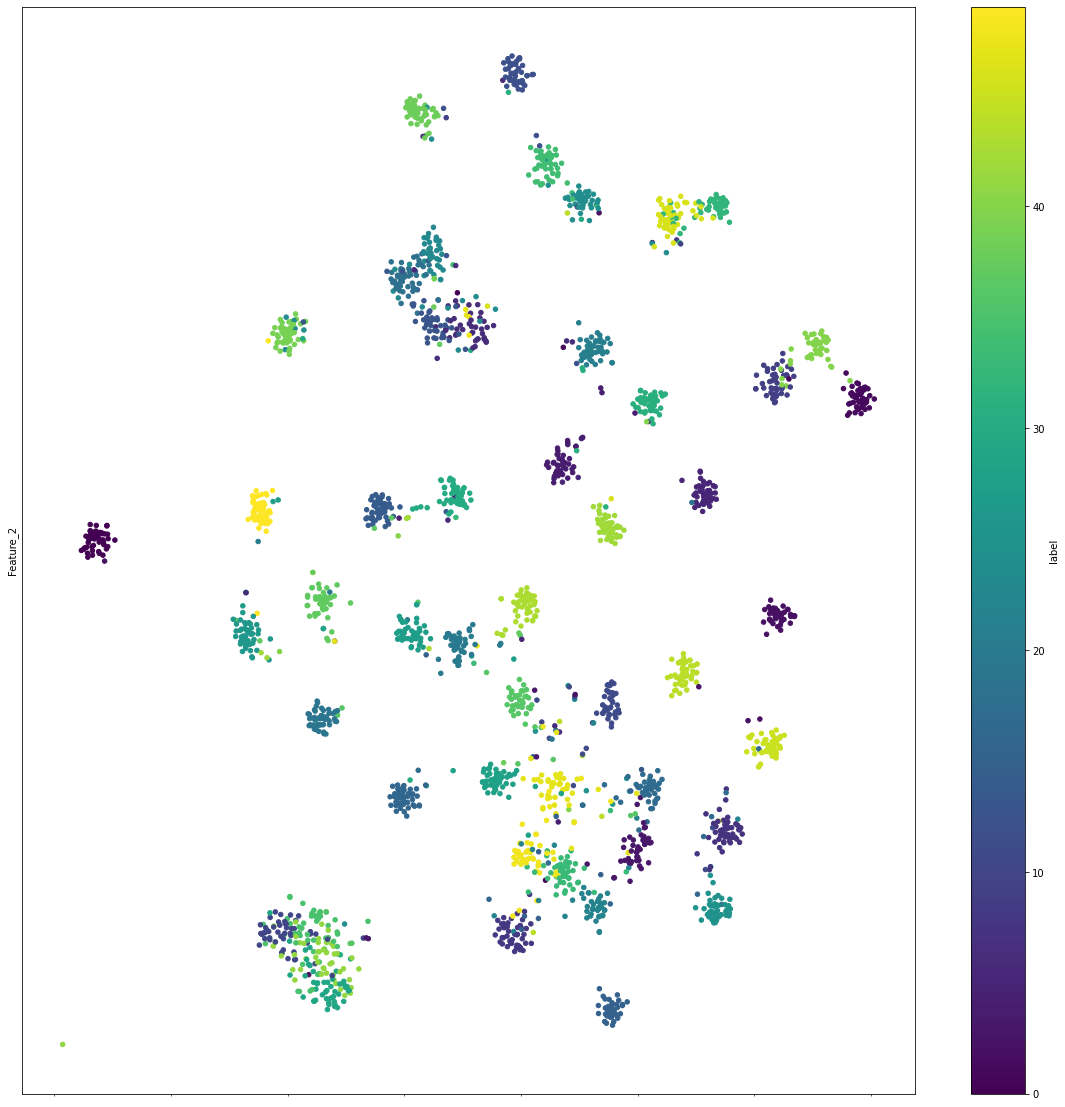

In [160]:
# https://mortis.tech/2019/11/program_note/664/

import matplotlib.pyplot as plt
from sklearn import manifold, datasets

# # t-SNE
X = outputs
X_tsne = manifold.TSNE(n_components=2, init='random', random_state=5, verbose=1, n_iter=2000).fit_transform(X)

#Data Visualization
x_min, x_max = X_tsne.min(0), X_tsne.max(0)
X_norm = (X_tsne - x_min) / (x_max - x_min)  #Normalize

df = pd.DataFrame(dict(Feature_1=X_tsne[:,0], Feature_2=X_tsne[:,1], label=y))
df.plot(x="Feature_1", y="Feature_2", kind='scatter', c='label', colormap='viridis', figsize=(20,20))

plt.xticks([])
plt.yticks([])
plt.show()